In [41]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
infile = r'files/event_data.csv'

def csv_to_df(infile, headers = []):
    if len(headers) == 0:
        df = pd.read_csv(infile)
    else:
        df = pd.read_csv(infile, header = None)
        df.columns = headers

    for r in range(10):
        try:
            df.rename( columns={'Unnamed: {0}'.format(r):'Unnamed{0}'.format(r)}, inplace=True )
        except:
            pass
    return df

df = csv_to_df(infile).rename_axis('id')


In [43]:
df['event_date'] = pd.to_datetime(df['event_date'])
df['week_number'] = df['event_date'].dt.isocalendar().week
df.dtypes

user_id                    object
event_date         datetime64[ns]
event_type                 object
purchase_amount           float64
week_number                UInt32
dtype: object

In [44]:

q = df.loc[df['week_number'] == 33]

q['user_id'].nunique()


5102

In [45]:


df_reg = df[df['event_type'] == 'registration']
df_reg = df_reg[['user_id', 'week_number']]
df_reg.columns = ['user_id', 'registration_week']

df = df.merge(df_reg, how='left', on='user_id')
df['cohort_lifetime'] = df['week_number'] - df['registration_week']

df

,user_id,event_date,event_type,purchase_amount,week_number,registration_week,cohort_lifetime
0,c40e6a,2019-07-29 00:02:15,registration,NaN,31,31,0
1,a2b682,2019-07-29 00:04:46,registration,NaN,31,31,0
2,9ac888,2019-07-29 00:13:22,registration,NaN,31,31,0
3,93ff22,2019-07-29 00:16:47,registration,NaN,31,31,0
4,65ef85,2019-07-29 00:19:23,registration,NaN,31,31,0
...,...,...,...,...,...,...,...
79737,930c23,2019-09-01 23:57:41,simple_event,NaN,35,32,3
79738,a84999,2019-09-01 23:57:50,simple_event,NaN,35,33,2
79739,175e4d,2019-09-01 23:59:40,simple_event,NaN,35,32,3
79740,1c2210,2019-09-01 23:59:51,simple_event,NaN,35,33,2


In [46]:

cohorts = df.pivot_table(index = ['registration_week','cohort_lifetime'], aggfunc = {'user_id':'nunique'}).reset_index() 

initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0]
initial_users_count = initial_users_count[['registration_week','user_id']]
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'}) 

initial_users_count

,registration_week,cohort_users
0,31,1975
5,32,1952
9,33,2045
12,34,1974
14,35,2050


In [47]:
cohorts = cohorts.merge(initial_users_count,on='registration_week')
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users'] 
retention_pivot = cohorts.pivot_table(index='registration_week', columns='cohort_lifetime', values='retention', aggfunc='sum') 

retention_pivot

cohort_lifetime,0,1,2,3,4
registration_week,,,,,
31,1.0,0.927595,0.629367,0.356962,0.15038
32,1.0,0.929303,0.648053,0.361168,NaN
33,1.0,0.924205,0.661125,NaN,NaN
34,1.0,0.929078,NaN,NaN,NaN
35,1.0,NaN,NaN,NaN,NaN


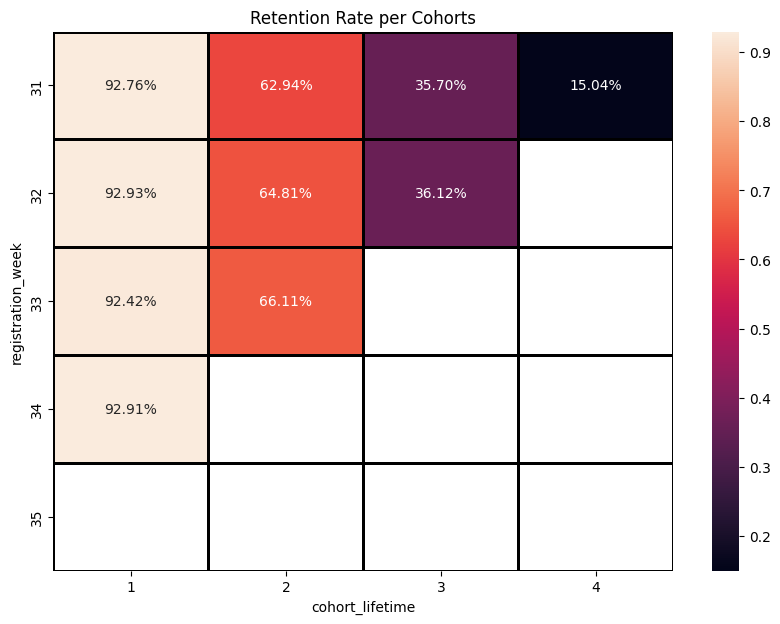

In [48]:
plt.figure(figsize=(10, 7))
plt.title('Retention Rate per Cohorts')
sns.heatmap(retention_pivot.iloc[:, 1:], annot=True, 
            fmt='.2%', linewidths=1, linecolor='black'); 